## Hotel in Jeju 
&nbsp;&nbsp;jeju hotel guest consumption eda

<strong>&nbsp;Target</strong><br><br>
``
'경제력이 있는 소비자층'
``

<strong>&nbsp;Use</strong>
- 내국인 관광객 대상 숙박 밀집 지역 파악<br><br>
    - 업종별 소비 데이터 
        - 제주 데이터 허브 '내국인, 관광객 업종별 소비내역' 데이터
        - 데이콘 '공간정보 탐색적 데이터 분석 경진대회' 데이터<br><br>
    - 호텔 사이트 (부킹닷컴) 스크래핑 <br>

<strong>&nbsp;Etc</strong><br>
- 카카오 Open API
    - reverse geocoding, geocoding

In [687]:
import pandas as pd
import numpy as np
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib import font_manager, rc
import dask.dataframe as dd
import json

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['axes.unicode_minus'] = False

# 한글 설정
f_path = "/Users/seyoung/Library/Fonts/AppleGothic.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

In [3]:
detailed_data_url = '../datas/detailed_consume_type_data.csv'
detailed_data = pd.read_csv(detailed_data_url, sep=',')

detailed_data.tail(3)

,YM,Sido,Sigungu,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,LargeCategory,MediumCategory
273180,202005,제주특별자치도,제주시,영세,편의점,x시,4800,0,1,0,950266.5976,1502457.688,소매업,체인화 편의점
273181,202005,제주특별자치도,제주시,중소,제과점,x시,25000,0,2,0,950524.6587,1500759.566,소매업,빵 및 과자류 소매업
273182,202005,제주특별자치도,제주시,영세,서양음식,x시,6000,0,1,0,950674.5989,1500760.286,음식점업,서양식 음식점업


제주 내 영향력있는 업종 (업종별 소비자 수, 소비횟수, 소비금액)

In [4]:
# 음식점업 기준 소분류, 중분류 총 이용 횟수, 총 이용 금액
restaurant_df = detailed_data[detailed_data['LargeCategory'] == '음식점업']

restaurant_pivot = restaurant_df.pivot_table(
    index=['MediumCategory', 'Type'], 
    values=['TotalSpent','NumofSpent', 'NumofDisSpent'], aggfunc='sum')
restaurant_pivot.sort_values('TotalSpent', axis=0, ascending=False)

NumofDisSpent  NumofSpent   TotalSpent
MediumCategory          Type                                         
한식 음식점업                 일반한식          120291      778824  28245133753
서양식 음식점업                서양음식           47854      420297   6000328366
일식 음식점업                 일식회집            5898       42528   2481301181
기타 주점업                  유흥주점               0       11498   2202130396
피자, 햄버거, 샌드위치 및 유사 음식점업 스넥             20283      114005   2049269707
중식 음식점업                 중국음식           10322       53597   1402394438
일반유흥 주점업                단란주점               0        6696   1182642040
                        주점              2433       23158    945025619
기타 주점업                  칵테일바               0        2343    168112330
일반유흥 주점업                주류판매점             44         783     46899750

### 제주 데이터 허브 (내국인, 관광객 업종별 소비내역)

In [772]:
consumption_data_url = '../datas/jeju_api_res_datas.csv'
consumption_data = pd.read_csv(consumption_data_url, sep=',',
                              names=['sigungu', 'marketType', 'userType', 'gender', 'userCount', 'useCount', 'useCost'])

consumption_data.rename(columns= consumption_data.iloc[0])
consumption_data.reset_index(drop=True).tail(3)

,sigungu,marketType,userType,gender,userCount,useCount,useCost
16697,제주시,소매,제주도민,남,806,1125,74823494
16698,제주시,문화/레져,내국인관광객,여,877,971,16823000
16699,제주시,숙박,내국인관광객,남,194,276,28666770


<strong>제주도민 업종 대분류별 소비분석</strong><br>

- 업종 이용 횟수, 소비자 수, 총 소비 금액

In [704]:
local_df = consumption_data[consumption_data['userType']=='제주도민'].reset_index(drop=True)

# 제주도민 업종별 합계 피벗 테이블
local_sum_pivot = (local_df.pivot_table(index='marketType', values=['useCount', 'useCost', 'userCount'], aggfunc='sum')
               .add_prefix('localSum_')).astype(int)

In [705]:
# 제주도민 업종별 단가 (업종별 총 소비 금액을 업종별 소비횟수로 나눔)
marketType = local_sum_pivot.index.tolist()
local_unitPrice = []

for i in range(len(marketType)):    
    target_row = local_sum_pivot[local_sum_pivot.index == marketType[i]]
    totalSpent_str = target_row.localSum_useCost.apply(str)
    spentNum_str = target_row.localSum_useCount.apply(str)

    totalSpent = ''.join(totalSpent_str[0])
    spentNum = ''.join(spentNum_str[0])

    unitPrice = round(int(totalSpent) / int(spentNum))
    local_unitPrice.append(unitPrice)
    
local_sum_pivot.insert(3, 'local_bill', local_unitPrice)
local_sum_pivot

,localSum_useCost,localSum_useCount,localSum_userCount,local_bill
marketType,,,,
교통,235596728034,4238506,2652361,55585
기타,274323891778,4170118,2098008,65783
문화/레져,68918393547,1888397,1214628,36496
소매,273535648466,3718984,2393921,73551
쇼핑,585591553849,28799681,8560011,20333
숙박,31680115747,319313,224588,99213
식음료,529335154776,18827193,8518080,28115
유흥,109368275375,951247,656706,114974


<strong>내국인 관광객 업종 대분류별 소비분석</strong><br>
- 업종 이용 횟수, 소비자 수, 총 소비 금액

In [706]:
guest_df = consumption_data[consumption_data['userType']=='내국인관광객'].reset_index(drop=True)

# 내국인 관광객 업종별 합계 피벗테이블
guest_sum_pivot = (guest_df.pivot_table(index='marketType', values=['useCount', 'useCost', 'userCount'], aggfunc='sum')
               .add_prefix('guestSum_')).astype(int)

In [707]:
# 내국인 관광객 업종별 단가 (업종별 총 소비 금액을 업종별 소비횟수로 나눔)
marketType = guest_sum_pivot.index.tolist()
guest_unitPrice = []

for i in range(len(marketType)):    
    target_row = guest_sum_pivot[guest_sum_pivot.index == marketType[i]]
    totalSpent_str = target_row.guestSum_useCost.apply(str)
    spentNum_str = target_row.guestSum_useCount.apply(str)

    totalSpent = ''.join(totalSpent_str[0])
    spentNum = ''.join(spentNum_str[0])

    unitPrice = round(int(totalSpent) / int(spentNum))
    guest_unitPrice.append(unitPrice)
    
guest_sum_pivot.insert(3, 'guest_bill', guest_unitPrice)
guest_sum_pivot

,guestSum_useCost,guestSum_useCount,guestSum_userCount,guest_bill
marketType,,,,
교통,199464890198,2979060,2522923,66956
기타,95426976177,2010343,1238926,47468
문화/레져,68955443253,1498791,1145961,46007
소매,137180163858,3159035,2530423,43425
쇼핑,361605687366,14583636,7206258,24795
숙박,100204671616,1020999,781350,98144
식음료,393586081344,12411585,8304869,31711
유흥,30604269530,261881,196747,116863


In [821]:
# concat
merge_df = pd.concat([local_sum_pivot, guest_sum_pivot], axis=1)
merge_df

,localSum_useCost,localSum_useCount,localSum_userCount,local_bill,guestSum_useCost,guestSum_useCount,guestSum_userCount,guest_bill
marketType,,,,,,,,
교통,235596728034,4238506,2652361,55585,199464890198,2979060,2522923,66956
기타,274323891778,4170118,2098008,65783,95426976177,2010343,1238926,47468
문화/레져,68918393547,1888397,1214628,36496,68955443253,1498791,1145961,46007
소매,273535648466,3718984,2393921,73551,137180163858,3159035,2530423,43425
쇼핑,585591553849,28799681,8560011,20333,361605687366,14583636,7206258,24795
숙박,31680115747,319313,224588,99213,100204671616,1020999,781350,98144
식음료,529335154776,18827193,8518080,28115,393586081344,12411585,8304869,31711
유흥,109368275375,951247,656706,114974,30604269530,261881,196747,116863


<strong>제주도민과 내국인 관광객 업종별 소비 단가</strong>
- 대분류 업종별 총 소비금액을 사용횟수로 나눴을 때 <U>제주도민과 내국인 관광객이 소비한 숙박 업종 단가는 비슷하다.</U>
- 하지만 <U>제주도민보다 내국인 관광객의 숙박 총 사용금액이 높다.</U>

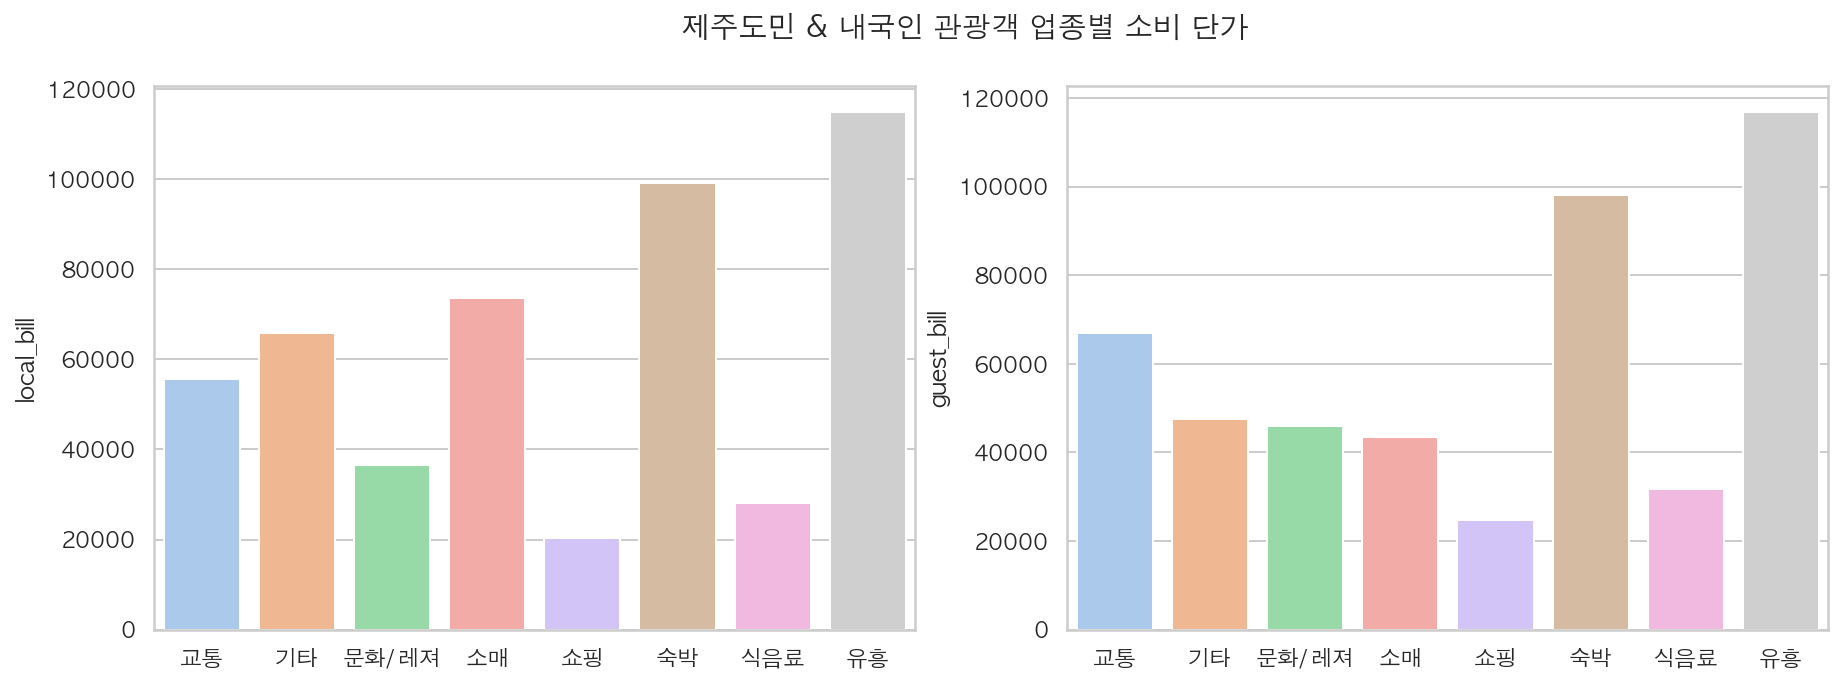

In [751]:
sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
sns.set_palette('pastel')

fig, axes = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('제주도민 & 내국인 관광객 업종별 소비 단가')

sns.barplot(ax=axes[0], x=marketType, y='local_bill', data=merge_df)
sns.barplot(ax=axes[1], x=marketType, y='guest_bill', data=merge_df)
plt.show()

In [906]:
# 숙박 관광객 / 내국인 useCost
target_series = merge_df.loc()[:][5:6]
target = target_series.iloc()[:,0:]
target.reset_index(drop=True, inplace=True)
target

localSum = target['localSum_useCost'].apply(str)
guestSum = target['guestSum_useCost'].apply(str)

localSum = int(''.join(localSum))
guestSum = int(''.join(guestSum))

accomodation_useCost = [localSum] + [guestSum]
accomodation_useCost

[31680115747, 100204671616]

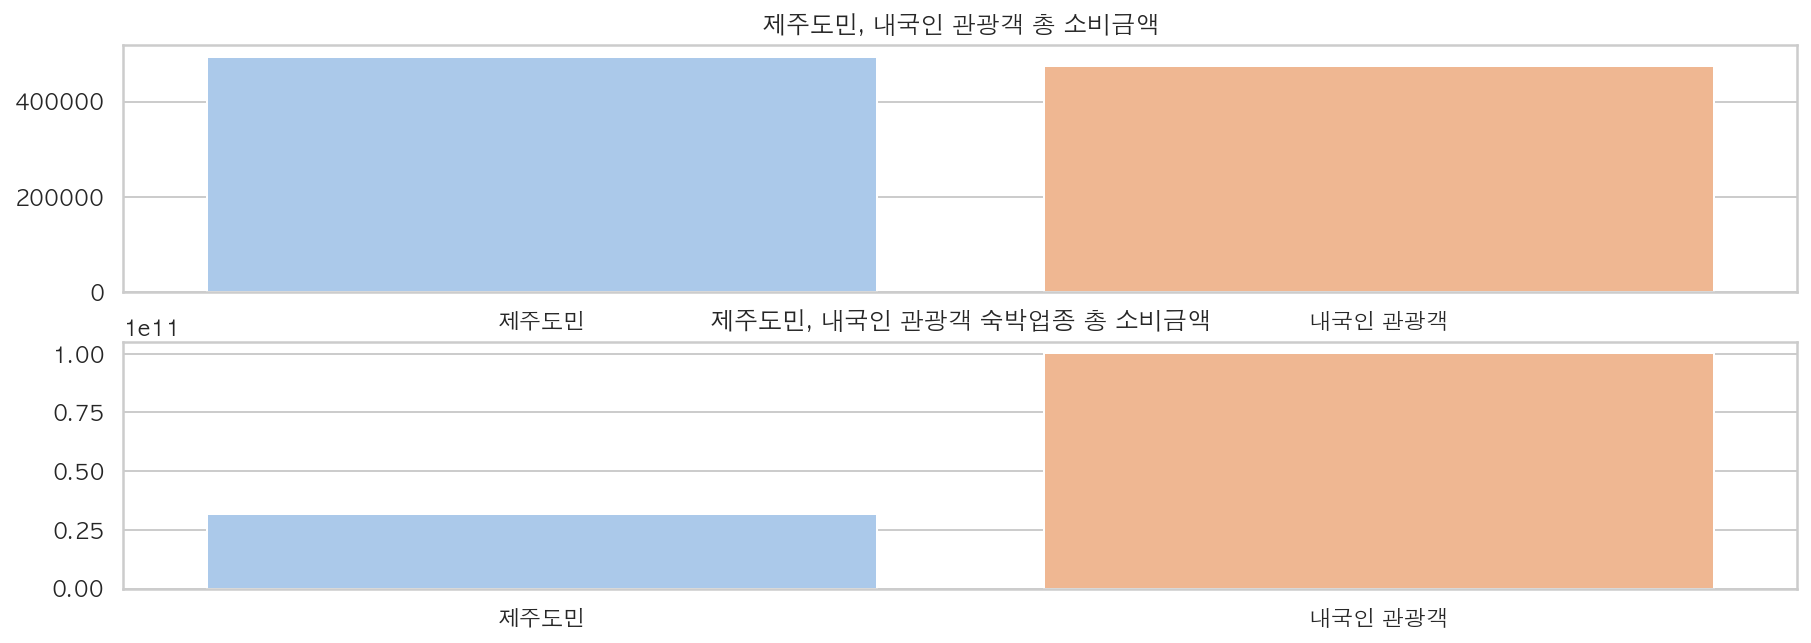

In [932]:
# 관광객 / 내국인 업종구분 x 총 useCost
local_total_bill = merge_df.iloc()[:, 3:4].sum().apply(str)
guest_total_bill = merge_df.iloc()[:, -1:].sum().apply(str)

local_total_bill = int(''.join(local_total_bill))
guest_total_bill = int(''.join(guest_total_bill))
bill = [local_total_bill] + [guest_total_bill]

sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
people=['제주도민', '내국인 관광객']

fig, axes = plt.subplots(2)
sns.set_palette('pastel')
ax = sns.barplot(x=people, y=bill, ax=axes[0]);
ax.set_title('제주도민, 내국인 관광객 총 소비금액');
ax = sns.barplot(x=people, y=accomodation_useCost, ax=axes[1]);
ax.set_title('제주도민, 내국인 관광객 숙박업종 총 소비금액');

local_rate : 제주도민 업종별 소비 비율<br>
guest_rate : 내국인 관광객 업종별 소비 비율

In [8]:
# 업종별 소비횟수 비율, 총 사용금액 비율, 소비자 비율
g_rate_cols = ['guest_rate_useCost', 'guest_rate_useCount', 'guest_rate_userCount']
l_rate_cols = ['local_rate_useCost', 'local_rate_useCount', 'local_rate_userCount']

guestConsume_cols = guest_sum_pivot.columns
localConsume_cols = local_sum_pivot.columns

for i in range(len(local_sum_pivot.columns)):
    guest_sum_pivot[g_rate_cols[i]] = (guest_sum_pivot[guestConsume_cols[i]] / guest_sum_pivot[guestConsume_cols[i]].sum()).astype(float) * 100
    local_sum_pivot[l_rate_cols[i]] = (local_sum_pivot[localConsume_cols[i]] / local_sum_pivot[localConsume_cols[i]].sum()).astype(float) * 100

guest_rate = guest_sum_pivot.drop(guestConsume_cols, axis=1) # 내국인 관광객
local_rate = local_sum_pivot.drop(localConsume_cols, axis=1) # 제주도민

In [9]:
total_rate = pd.concat([guest_rate, local_rate], axis=1)
total_rate.sort_values(by='local_rate_useCost', ascending=False) # 정렬

,guest_rate_useCost,guest_rate_useCount,guest_rate_userCount,local_rate_useCost,local_rate_useCount,local_rate_userCount
marketType,,,,,,
쇼핑,26.070536,38.453551,30.117108,27.774877,45.776676,32.524935
식음료,28.376214,32.726373,34.708532,25.106610,29.925551,32.365613
기타,6.879959,5.300792,5.177842,13.011309,6.628342,7.971669
소매,9.890222,8.329618,10.575395,12.973922,5.911271,9.096031
교통,14.380738,7.855067,10.544050,11.174461,6.737044,10.078009
유흥,2.206463,0.690517,0.822265,5.187388,1.511993,2.495244
문화/레져,4.971452,3.951952,4.789314,3.268831,3.001580,4.615146
숙박,7.224415,2.692130,3.265495,1.502602,0.507543,0.853353


In [11]:
# matplotlib dark theme style
# from matplotlib import style

# style.available
# style.use('bmh')

<strong>제주도민과 내국인 관광객의 업종 대분류별 소비금액, 소비횟수, 이용객 수 비교</strong><br>
- 교통과 기타를 제외한 나머지 업종을 비교할 때 <U>동일 소비횟수, 이용객 수 대비 숙박업종에서 내국인 관광객의 소비 금액이 크다.</U>
- 호텔에 묵는 내국인 관광객이 소비력이 있다?

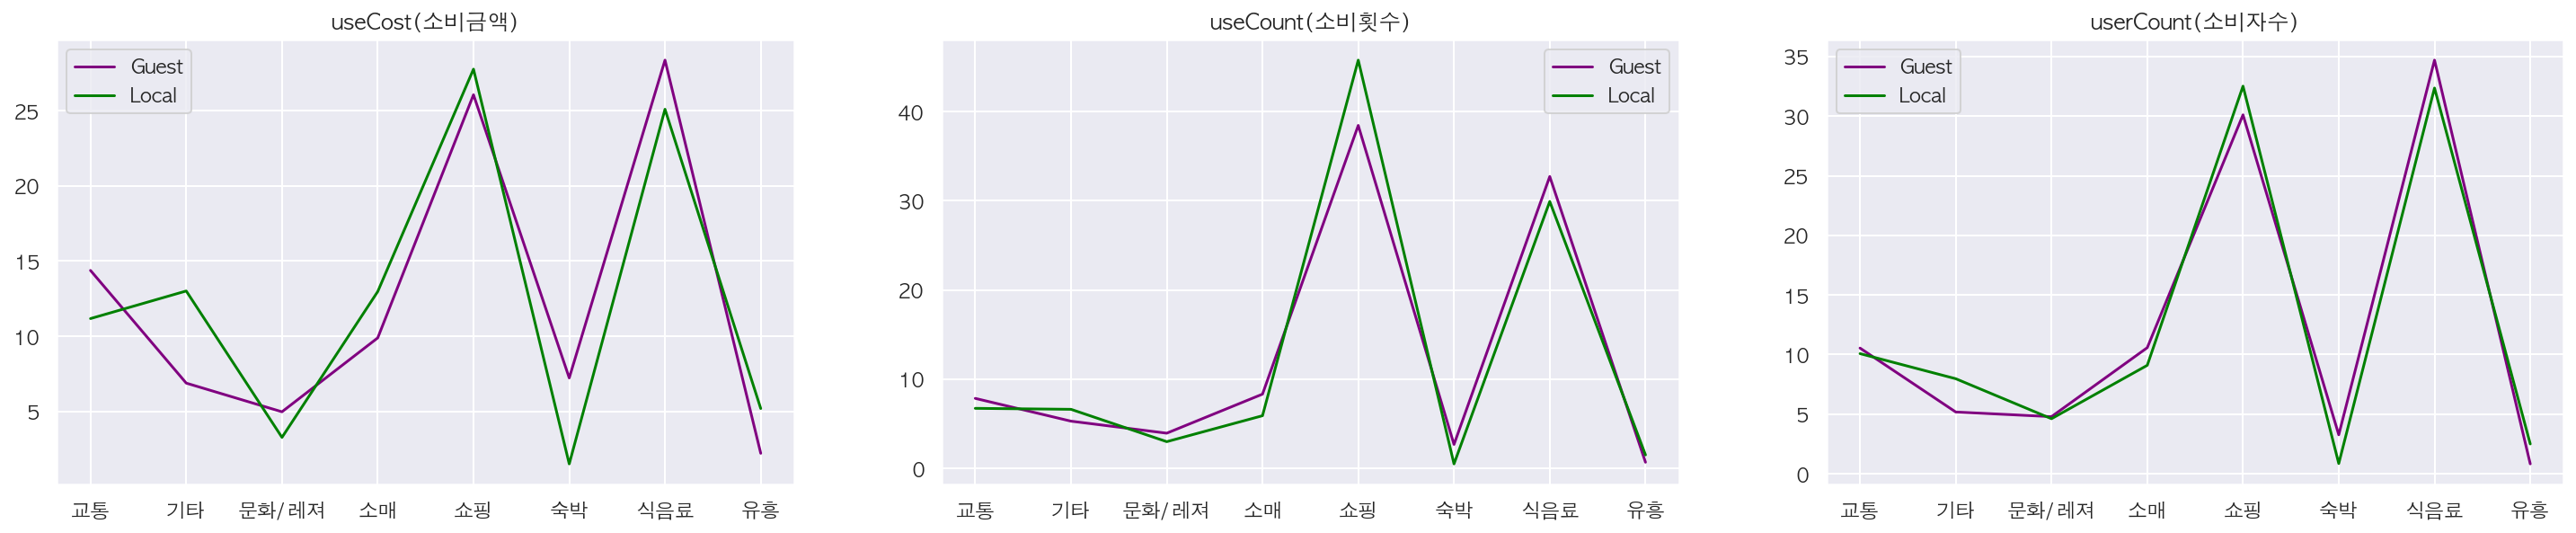

In [13]:
plt.figure(figsize=(25,10))
cols = int(len(total_rate.columns)/2)
line_labels = ['Guest', 'Local']
plt_titles = ['useCost(소비금액)', 'useCount(소비횟수)', 'userCount(소비자수)']

for i in range(cols):
    plt.subplot(2,3,i+1)
    plt.plot(total_rate.index[:], total_rate[total_rate.columns[i]], color='purple')
    plt.plot(total_rate.index[:], total_rate[total_rate.columns[i+3]], color='green')
    plt.title(plt_titles[i])
    plt.legend(labels=line_labels)

plt.show()

-----
### Hotel Data

In [304]:
hotel_data_url = '../datas/detailed_consume_type_data_hotel.csv'
datas = pd.read_csv(hotel_data_url, sep=',')

# Type = '콘도' 제외
datas = datas.iloc()[:,3:].reset_index(drop=True)
drop_rows = datas.index[datas['Type'] == '콘도'].tolist()
hotel_datas = datas.drop(index=drop_rows)

# TotalSpent에서 DisSpent제외한 순수매출
hotel_datas['TotalSpent'] -= hotel_datas['DisSpent']
hotel_datas.tail(3)

,Sigungu,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,LargeCategory,MediumCategory,Proj_X,Proj_Y
7370,제주시,영세,기타숙박업,x시,240000,0,2,0,921960.8140,1505970.235,숙박업,여관업,126.657295,33.545616
7374,서귀포시,영세,기타숙박업,x시,96020,0,3,0,940664.1457,1493315.085,숙박업,여관업,126.859582,33.432683
7376,서귀포시,영세,기타숙박업,x시,40000,0,1,0,947293.2310,1497145.416,숙박업,여관업,126.930666,33.467577


<strong>숙박업종 시간대별 소비 금액, 소비 횟수</strong><br>
- 호텔의 경우 체크인과 체크아웃이 활발하게 발생하는 <U>오전 9시 ~ 11시, 오후 1시 ~ 2시에 소비금액이 가장 크다.</U>
- 기타 숙박업은 <U>오후 3시 ~ 8시에 소비 횟수가 많이 발생된다.</U>

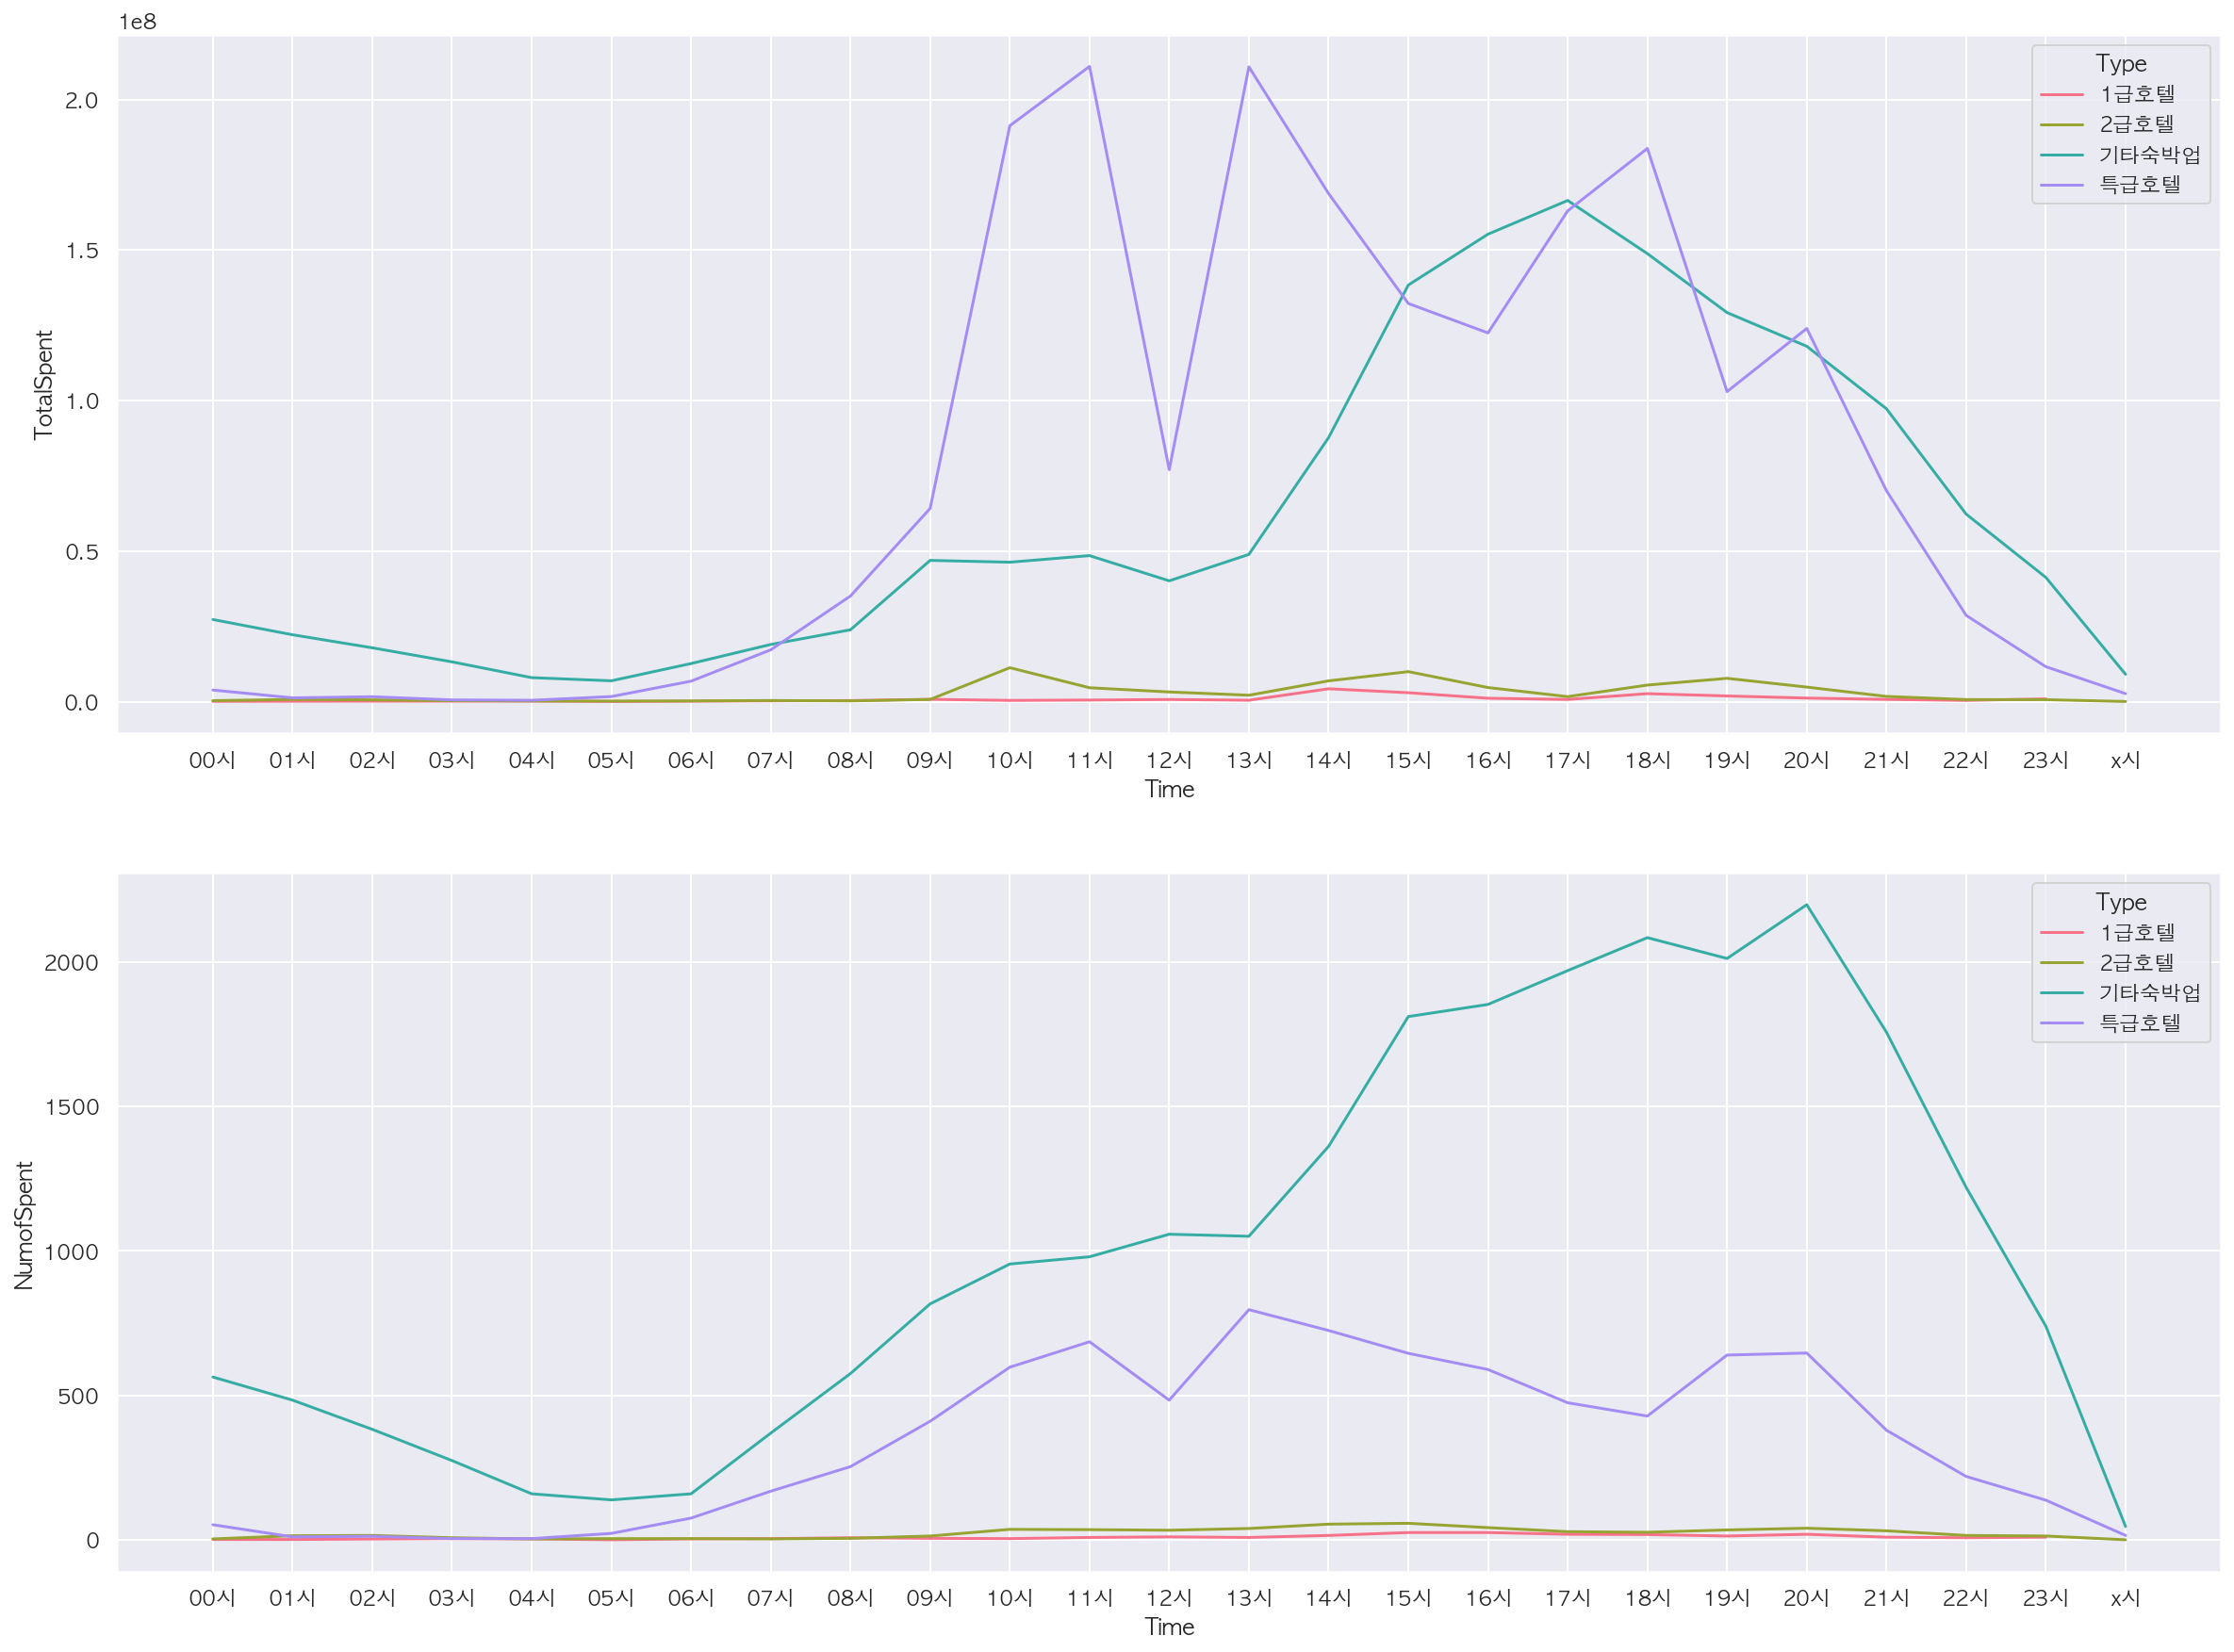

In [311]:
# Time based indexing
time_based_pivot = hotel_datas.pivot_table(index=['Time','Type'], values=['TotalSpent', 'NumofSpent'], aggfunc='sum')

# time = list(set([time_based_pivot.index[i][0] for i in range(len(time_based_pivot))]))

# time 기준 Type별 NumofSpent, TotalSpent
time_based_pivot.reset_index(inplace=True)
time_based_pivot

fig, axes = plt.subplots(2)
sns.set(rc={'figure.figsize':(20,15),'axes.unicode_minus':False}, font='AppleGothic', style='darkgrid')

with sns.color_palette('husl', 3):
    sns.lineplot(x='Time', y='TotalSpent', hue='Type', data=time_based_pivot, ax=axes[0]);
    sns.lineplot(x='Time', y='NumofSpent', hue='Type', data=time_based_pivot, ax=axes[1]);

<strong>기타숙박업을 포함한 숙박업종 내 소비가 일어나는 지역</strong>
- 숙박업을 이용한 고객의 결제 데이터를 x, y 좌표로 확인
- 기타 숙박업의 비중이 압도적으로 많은 것을 확인할 수 있다.

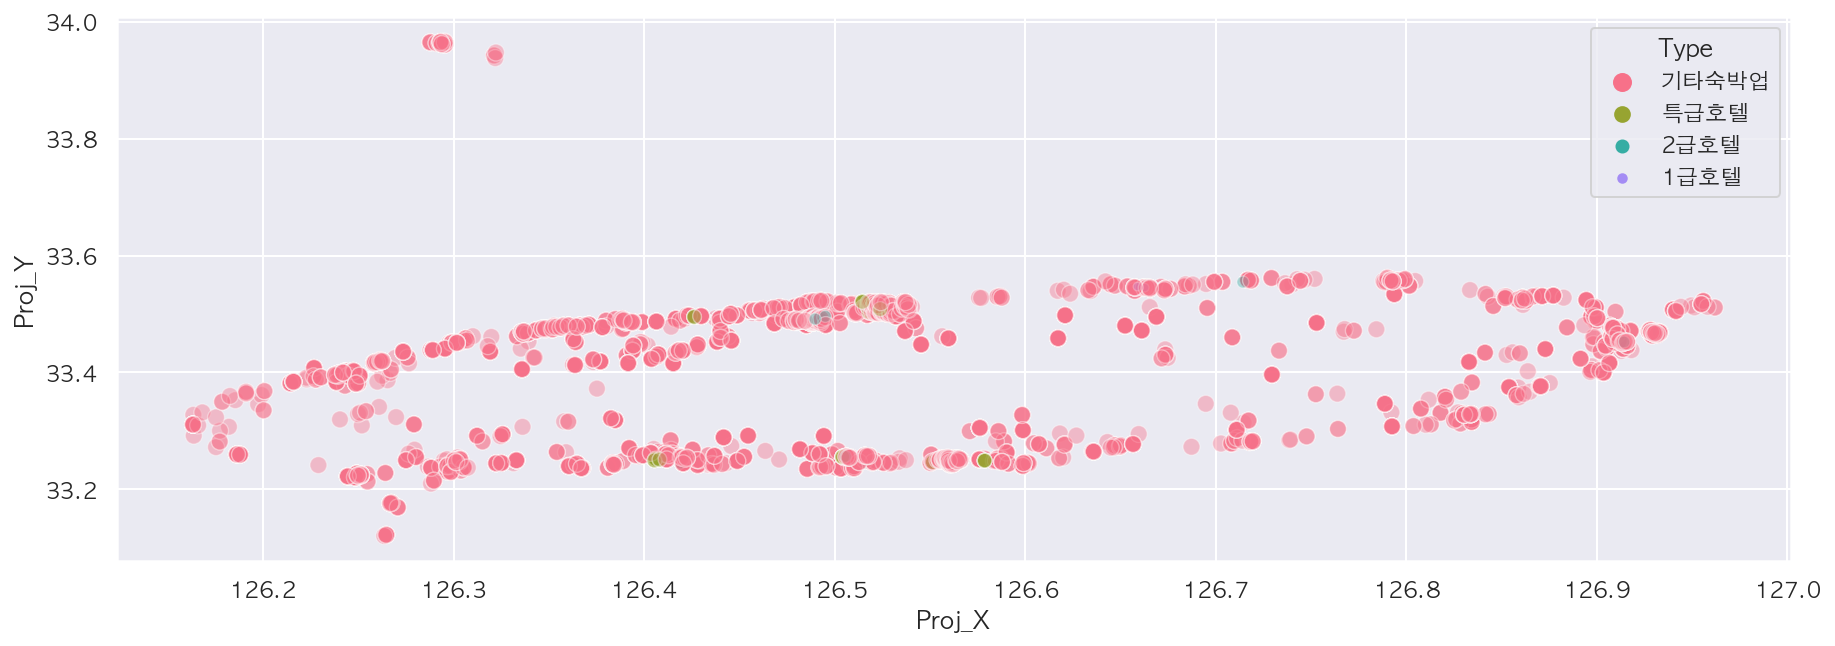

In [933]:
sns.set(rc={'figure.figsize':(15,5),'axes.unicode_minus':False}, font='AppleGothic', style='darkgrid')
with sns.color_palette('husl', 3):
    ax = sns.scatterplot(x='Proj_X', y='Proj_Y', 
                         data=hotel_datas, hue='Type', alpha=0.4, size='Type')

<strong>기타 숙박업 제외</strong>
- 주로 소비를 많이할 것으로 예상되는 <U>'내국인 관광객이면서 호텔 이용객'을 타겟</U>으로 하고자 하므로 
- 기타 숙박업을 제외한 x,y 좌표를 확인한다.

In [312]:
# type = '기타숙박업' 제외
drop_rows = hotel_datas.index[hotel_datas['Type'] == '기타숙박업'].tolist()
drop_etc_accomodation = hotel_datas.drop(index=drop_rows)
drop_etc_accomodation.reset_index(inplace=True)
drop_etc_accomodation = drop_etc_accomodation.drop('index', axis=1)
drop_etc_accomodation.tail(3)

,Sigungu,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,LargeCategory,MediumCategory,Proj_X,Proj_Y
539,제주시,일반,특급호텔,x시,300000,0,2,0,908678.9024,1503357.462,숙박업,호텔업,126.514514,33.520999
540,제주시,일반,특급호텔,x시,12600,0,2,0,909535.2455,1501962.168,숙박업,호텔업,126.523875,33.508489
541,서귀포시,일반,특급호텔,x시,39000,0,1,0,914371.1918,1473147.432,숙박업,호텔업,126.578676,33.249018


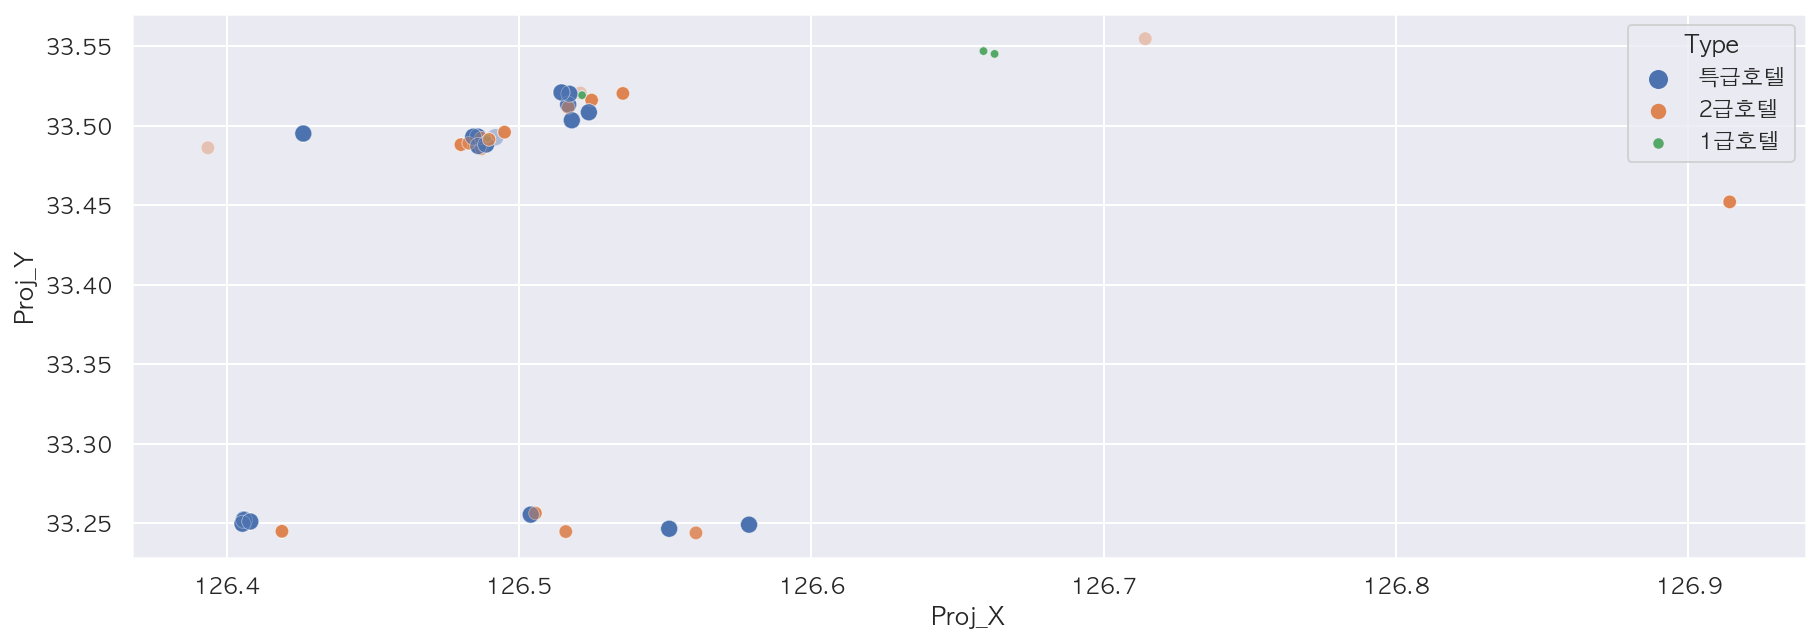

In [313]:
sns.set(rc={'figure.figsize':(15,5),'axes.unicode_minus':False}, font='AppleGothic', style='darkgrid')
sns.scatterplot(x='Proj_X', y='Proj_Y', data=drop_etc_accomodation, hue='Type', alpha=0.4, size='Type');

일부 지역의 호텔에서 소비가 이뤄졌음을 알 수 있다.
- xlim, ylim 확대

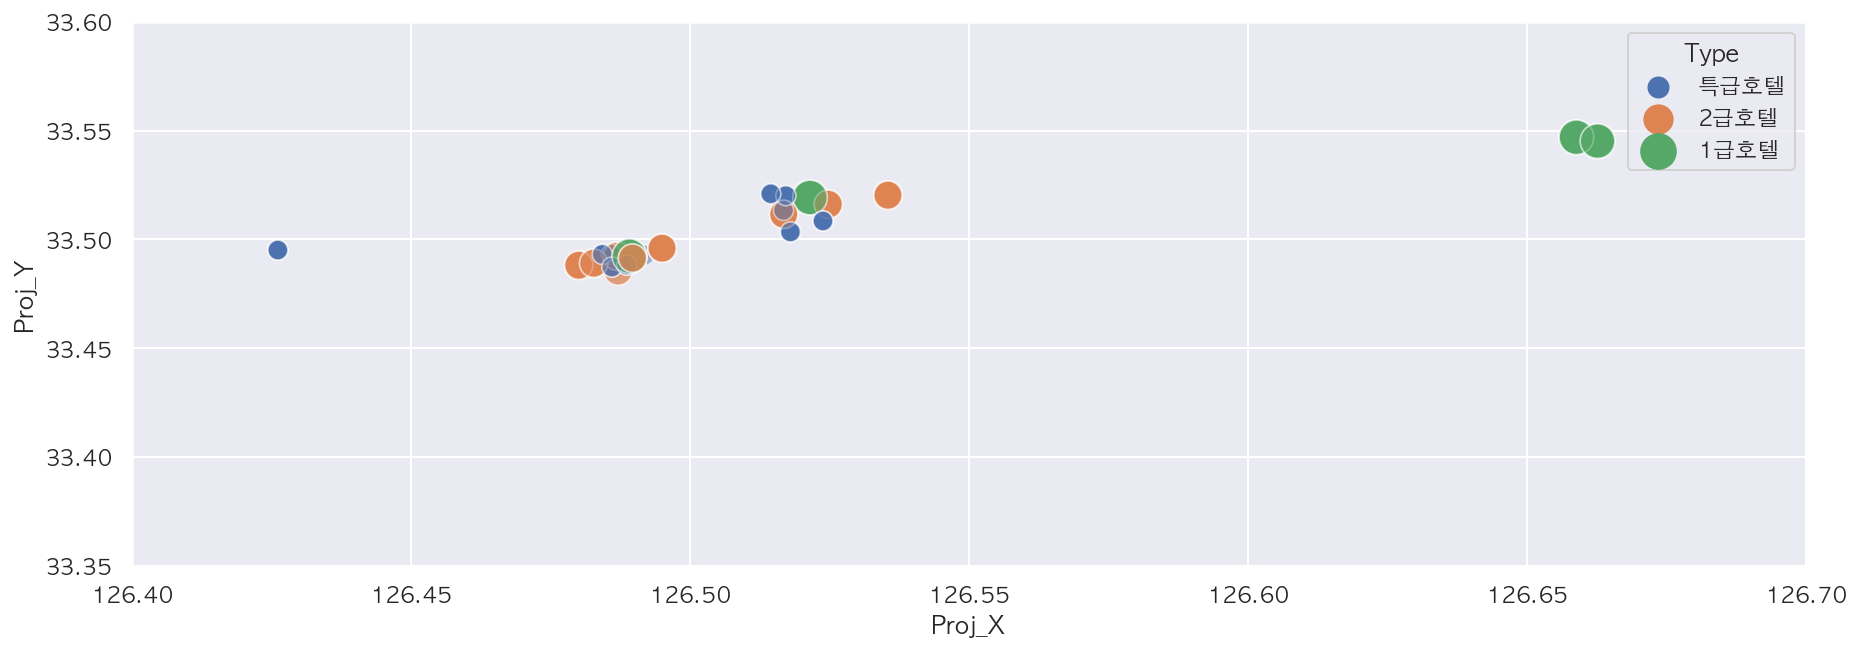

In [314]:
# xlim, ylim
plt = sns.scatterplot('Proj_X', 'Proj_Y', data=drop_etc_accomodation, hue='Type', alpha=0.5, size='Type', sizes=(300,100))
plt.set(ylim=(33.35, 33.6))
plt.set(xlim=(126.4, 126.7));

---
### Scraping Hotel Data 
부킹닷컴(https://www.booking.com/) 내 제주 호텔 데이터를 수집<br><br>
``
04/30 ~ 05/01, 05/16 ~ 05/17 기준
``
- 호텔명, 성급, 평점, 기준가격, 현재가격, 긍정적 리뷰, 부정적 리뷰, 주소

In [290]:
# scraping_data_url = '../datas/jeju_hotel_datas.csv'  # 리뷰내용 포함
data_url = '../datas/jeju_hotel_pivot.csv'

# hotel_data = pd.read_csv(scraping_data_url, sep=',')
hotel_data = pd.read_csv(data_url, sep=',')
# hotel_data = hotel_data.iloc()[:,1:9]
hotel_data.tail(3)

,name,num,avg_star,avg_grade,avg_basePrice,avg_currentPrice,avg_good review,avg_bad review,addr,kor_addr
517,휘닉스 제주 섭지코지,1,5.0,8.0,"501,316","300,000",1.0,1.0,"서귀포, 성산읍 섭지코지로 107","서귀포, 성산읍 섭지코지로 107"
518,휴 안 스테이,2,3.0,9.0,"40,824",NaN,2.0,2.0,"서귀포, 성산읍 성산중앙로37번길 9","서귀포, 성산읍 성산중앙로37번길 9"
519,히든 클리프 호텔&네이쳐,1,5.0,8.0,"440,267","286,000",1.0,1.0,"서귀포, 예래해안로 550","서귀포, 예래해안로 550"


<strong>호텔 데이터 주소 위도, 경도 값으로 변환</strong><br>
- Kakao Open API 사용

In [291]:
# api key 호출
def get_secretKeys():
    file = open("../keys/secret_keys.txt", "rt")
    split_keys = []
    line_count = 0
    
    load_datas = file.readlines()
    
    file.close()
    
    for i in range(len(load_datas)):
        split_keys.append(load_datas[i].split('=')[1].replace('"', ""))
    
    return split_keys

In [292]:
# api 요청 url 생성
def get_search_url(addr):
    api_keys = get_secretKeys()
    
    base = 'https://dapi.kakao.com/v2/local/search/address.json'
    header_phrase = 'KakaoAK'
    api_key = api_keys[1]
    
    headers = {'Authorization': header_phrase + api_key[1:]}
    req_param = '?query=' + str(addr)
    url = base + req_param
    
    return url, headers

In [293]:
# api 요청 응답
def get_result(url, headers):
    req = requests.get(url, headers=headers)
    res = json.loads(req.text)
    
    return res

In [294]:
# 응답 데이터 파싱
def json_parsing(res):
    
    res_dict = res['documents']
    x = res_dict[0]['x']
    y = res_dict[0]['y']
    
    return x, y

In [295]:
# 호텔 주소 데이터 위도 경도 변환 수행
addr_col = hotel_data.iloc()[:, -1:]
addr_list = [addr_col.loc()[i].tolist() for i in range(len(hotel_data))]

lat, lng = [], []

for i in range(len(addr_list)):
    target = addr_list[i]
    url, headers = get_search_url(target)
    res = get_result(url, headers)
    
    try:
        x, y = json_parsing(res)
        lat.append(x)
        lng.append(y)
        
    except:
        lat.append(0)
        lng.append(0)

len(lat), len(lng)

(520, 520)

In [296]:
lat = pd.DataFrame(columns=['x'], data=lat)
lng = pd.DataFrame(columns=['y'], data=lng)

# drop 0
drop_lat_list = lat.index[lat['x'] == 0.0].tolist()
drop_lat_zero = lat.drop(index=drop_lat_list)
drop_lat_zero.reset_index(drop=True, inplace=True)

drop_lng_list = lng.index[lng['y'] == 0.0].tolist()
drop_lng_zero = lng.drop(index=drop_lng_list)
drop_lng_zero.reset_index(drop=True, inplace=True)

In [297]:
lat = [drop_lat_zero.loc()[i][0] for i in range(len(drop_lat_zero))]
lng = [drop_lng_zero.loc()[i][0] for i in range(len(drop_lng_zero))]

rd_lat = [round(float(lat[i]), 6) for i in range(len(lat))]
rd_lng = [round(float(lng[i]), 6) for i in range(len(lng))]

type(rd_lat), type(rd_lng)

In [300]:
lat_df = pd.DataFrame(columns=['x'], data=rd_lat)
lng_df = pd.DataFrame(columns=['y'], data=rd_lng)

hotel_data = pd.concat([hotel_data, lat_df, lng_df], axis=1)

In [342]:
hotel_data.head(4)

,name,num,avg_star,avg_grade,avg_basePrice,avg_currentPrice,avg_good review,avg_bad review,addr,kor_addr,x,y
0,At corner resort & garden,1,3.0,9.0,"132,000",NaN,1.0,1.0,"제주, 25, Baekpobuk-gil",제주 백포북길 25,126.458947,33.502902
1,Baraquera Hotel,2,4.0,8.0,"125,946",NaN,2.0,2.0,"서귀포, 6, Chilsimni-ro 504beon-gil","서귀포, 칠십리로 504번길",126.604286,33.241092
2,BK 호텔 제주,2,3.0,8.0,"47,520","47,520",2.0,2.0,"서귀포, 칠십리로91번길 12","서귀포, 칠십리로91번길 12",126.564275,33.241038
3,DaeJeong Pension,1,3.0,9.0,"58,000",NaN,1.0,1.0,"서귀포, 29, Hamobaeksa-ro, Dajeong-eup","서귀포, 하모백사로 29 대정읍",126.259040,33.214267


<strong>실제 제주 내 호텔 분포</strong>
- 숙박업종 이용객 데이터와 유사하게 분포되어 있다.
- 3성급의 비중이 매우 많다.

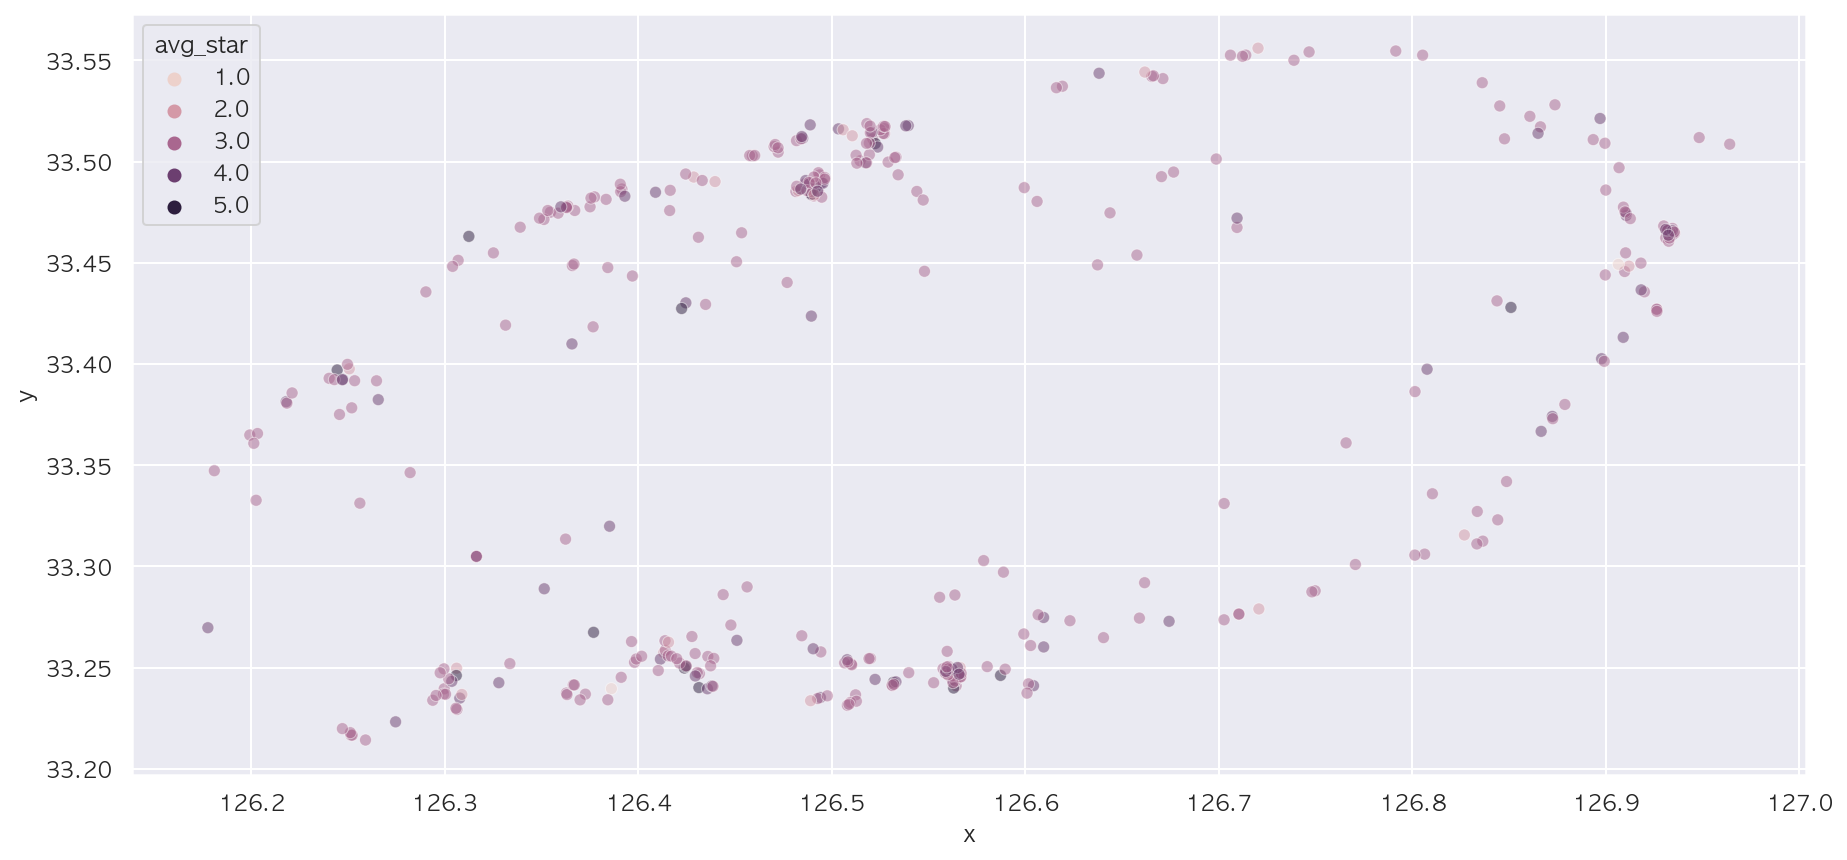

In [337]:
# 실제 제주 내 호텔 분포
sns.set(rc={'figure.figsize':(15,7),'axes.unicode_minus':False}, font='AppleGothic', style='darkgrid')
sns.scatterplot(x='x', y='y', data=hotel_data, hue='avg_star', alpha=0.5);

In [934]:
cols = hotel_data.columns.drop('avg_star').tolist()
hotel_pivot = hotel_data.pivot_table(index='avg_star', values=cols, aggfunc='sum')

hotel_distribution = hotel_pivot.iloc()[:,:-2]
hotel_distribution.index = hotel_distribution.index.astype(int)
hotel_distribution

,avg_bad review,avg_good review,avg_grade,num
avg_star,,,,
1,3.0,3.0,9.0,3
2,50.0,50.0,126.0,63
3,519.0,523.0,2176.0,572
4,145.0,169.0,561.0,182
5,20.0,40.0,141.0,40


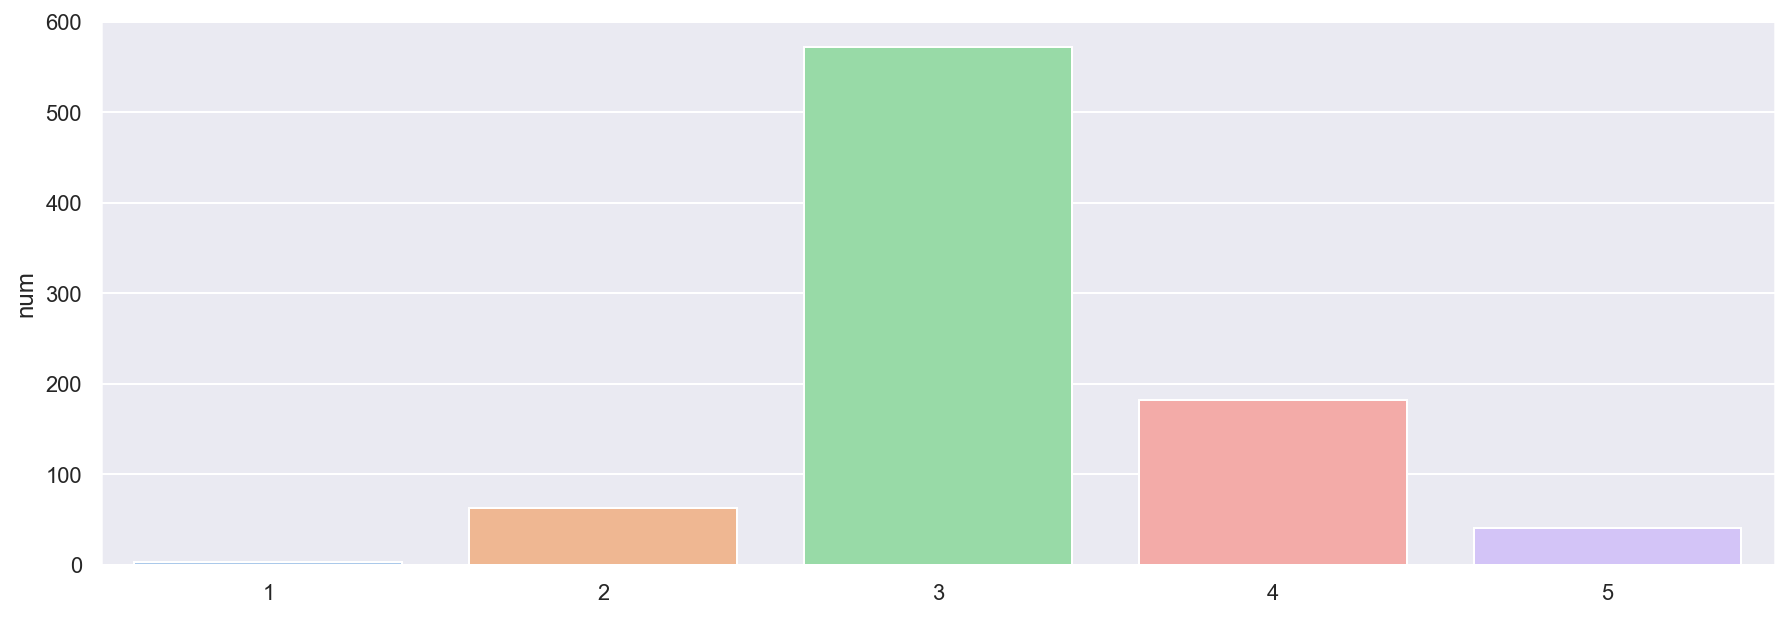

In [936]:
# 제주 내 호텔 성급별 분포 비율
sns.set(rc={'figure.figsize':(15,5)})
sns.set_palette('pastel')
sns.barplot(data=hotel_distribution, x=hotel_distribution.index.tolist(), y='num');

<strong>호텔 이용객 소비 데이터와 실제 제주 내 호텔 분포를 합치기</strong></br>
- scatterplot 기준 위, 아래에서 호텔 이용객의 소비가 이루어짐을 알 수 있다. 

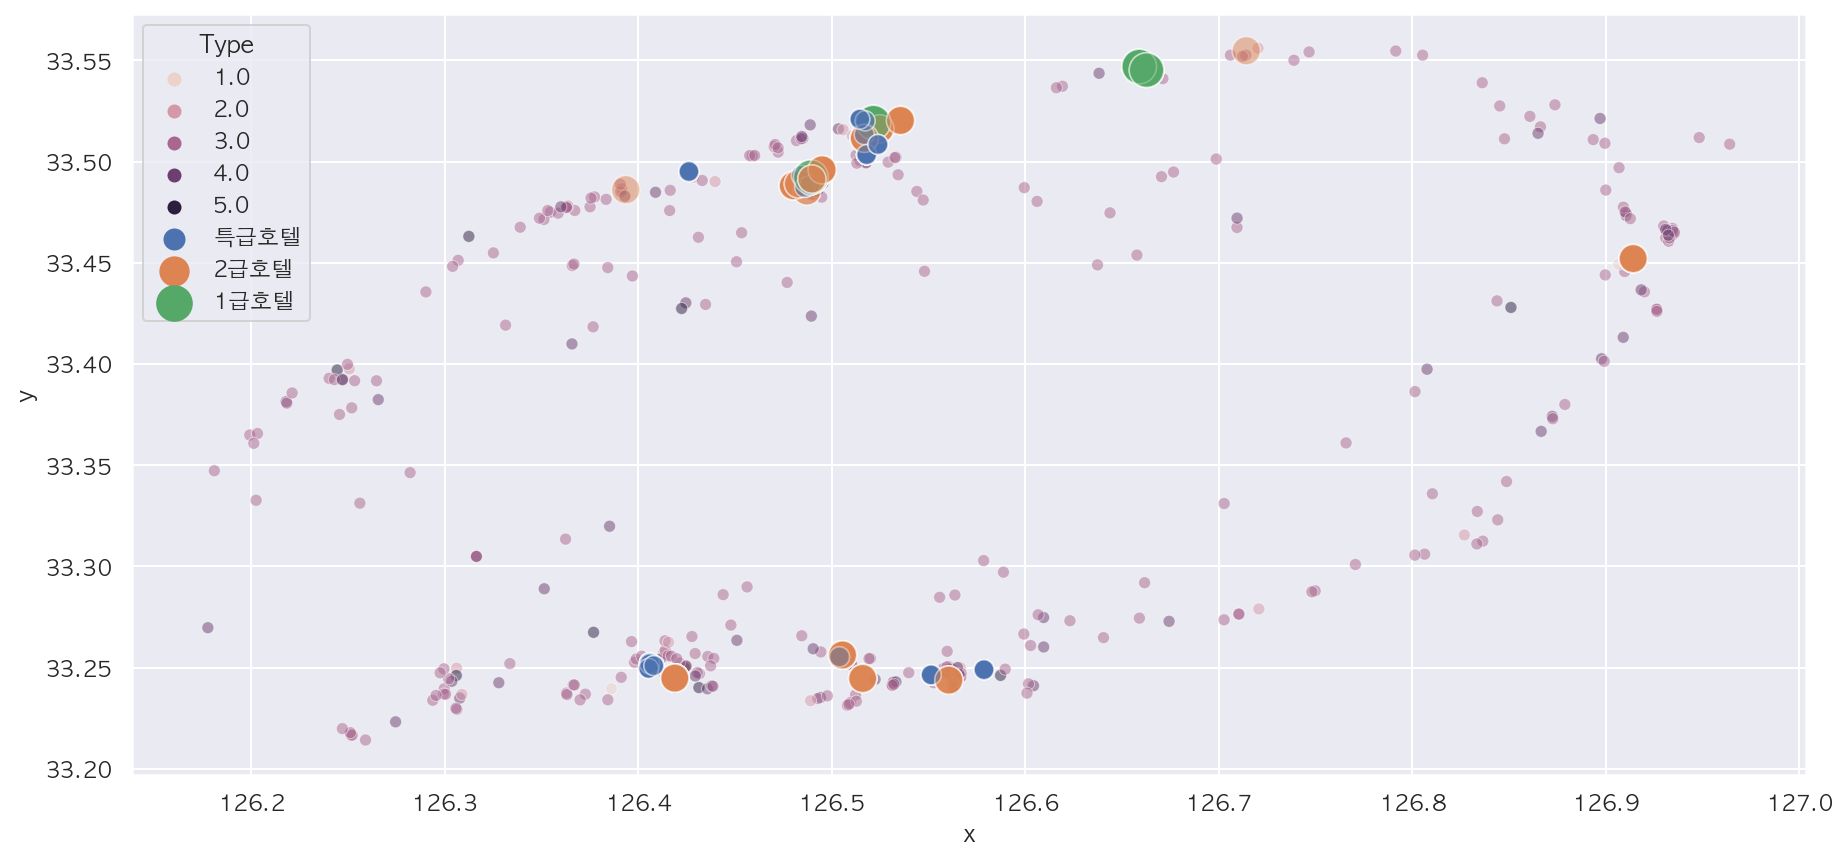

In [336]:
# 실제 제주내 호텔 분포와 관광객&내국인의 호텔 소비를 겹친 scatterplot
sns.set(rc={'figure.figsize':(15,7),'axes.unicode_minus':False}, font='AppleGothic', style='darkgrid')
sns.scatterplot(x='x', y='y', hue='avg_star', data=hotel_data, alpha=0.5);
sns.scatterplot('Proj_X', 'Proj_Y', data=drop_etc_accomodation, hue='Type', alpha=0.5, size='Type', sizes=(300,100));

In [370]:
# 1,2,3 성급을 제외한 실제 4,5 성급 호텔
options = [4.0, 5.0]

df = pd.DataFrame(hotel_data, columns=hotel_data.columns)
df = hotel_data[hotel_data['avg_star'].isin(options)]
len(df)

88

<strong>1,2,3성급을 제외한 호텔 분포</strong>

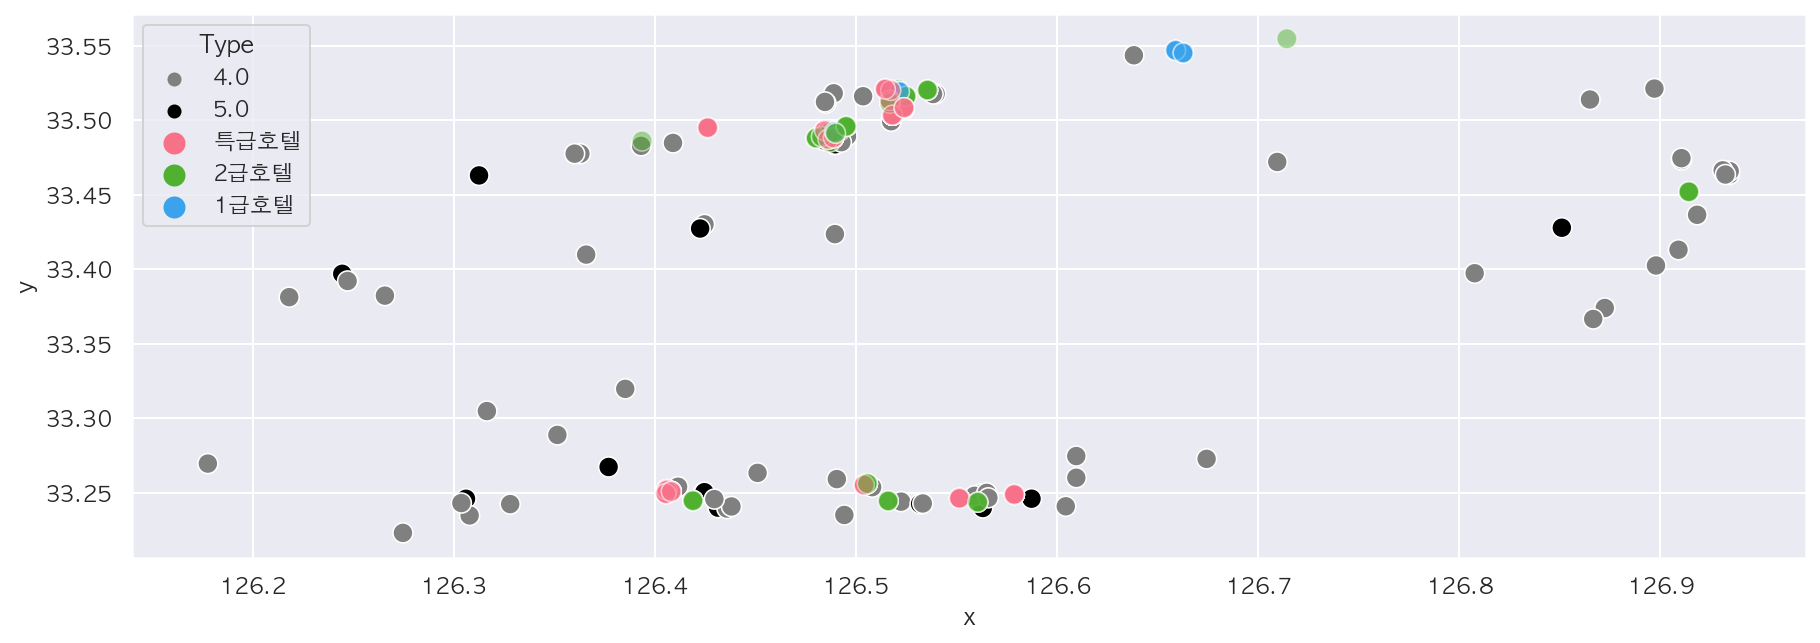

In [512]:
# 1,2,3 성급을 제외한 호텔과 실제 호텔 소비를 겹친 scatterplot
sns.set(rc={'figure.figsize':(15,5),'axes.unicode_minus':False}, font='AppleGothic')
with sns.color_palette('husl', 3):
    sns.scatterplot('x', 'y', hue='avg_star', data=df, s=100, palette=['grey','black']);     
    sns.scatterplot('Proj_X', 'Proj_Y', data=drop_etc_accomodation, hue='Type', alpha=0.5, size='Type', sizes=(100,100));

<strong>K-Means Clustering</strong><br>
- 호텔 이용객 결제 데이터 호텔 좌표와 부킹닷컴에서 크롤링한 실제 호텔 좌표를 합친 값으로 클러스터링
- (4,5 성급 호텔, 특급호텔, 2급호텔, 1급호텔 기준)
- 여관업, 펜션, 콘도 등을 포함한 기타 숙박업은 제외

In [473]:
# 호텔 결제 데이터 좌표와 제주내 호텔 분포 좌표를 합친다.
drop_etc_accomodation.tail(3)
point_xy = drop_etc_accomodation.iloc()[:,12:14]
point_xy.rename(columns={'Proj_X':'x', 'Proj_Y':'y'}, inplace=True)

df.tail(3)
xy = df.iloc()[:, 10:12]
xy.reset_index(inplace=True, drop=True)

In [482]:
# 호텔 결제 데이터 x,y + 제주 호텔 분포 x,y
positions = pd.DataFrame(columns=['x', 'y'])
positions = pd.concat([point_xy, xy], axis=0)
positions.reset_index(inplace=True, drop=True)
positions.dropna()

,x,y
0,126.405867,33.251886
1,126.405859,33.252337
2,126.426181,33.495118
3,126.482779,33.489061
4,126.484322,33.493136
...,...,...
622,126.492669,33.485388
623,126.483968,33.486465
624,126.484510,33.512399
625,126.565765,33.246774


In [485]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
positions = positions.dropna()
feature = positions
model.fit(feature)

predict = pd.DataFrame(model.predict(feature), columns=['cluster'])
feature = pd.concat([feature, predict], axis=1)
feature.head()

,x,y,cluster
0,126.405867,33.251886,1
1,126.405859,33.252337,1
2,126.426181,33.495118,0
3,126.482779,33.489061,0
4,126.484322,33.493136,0


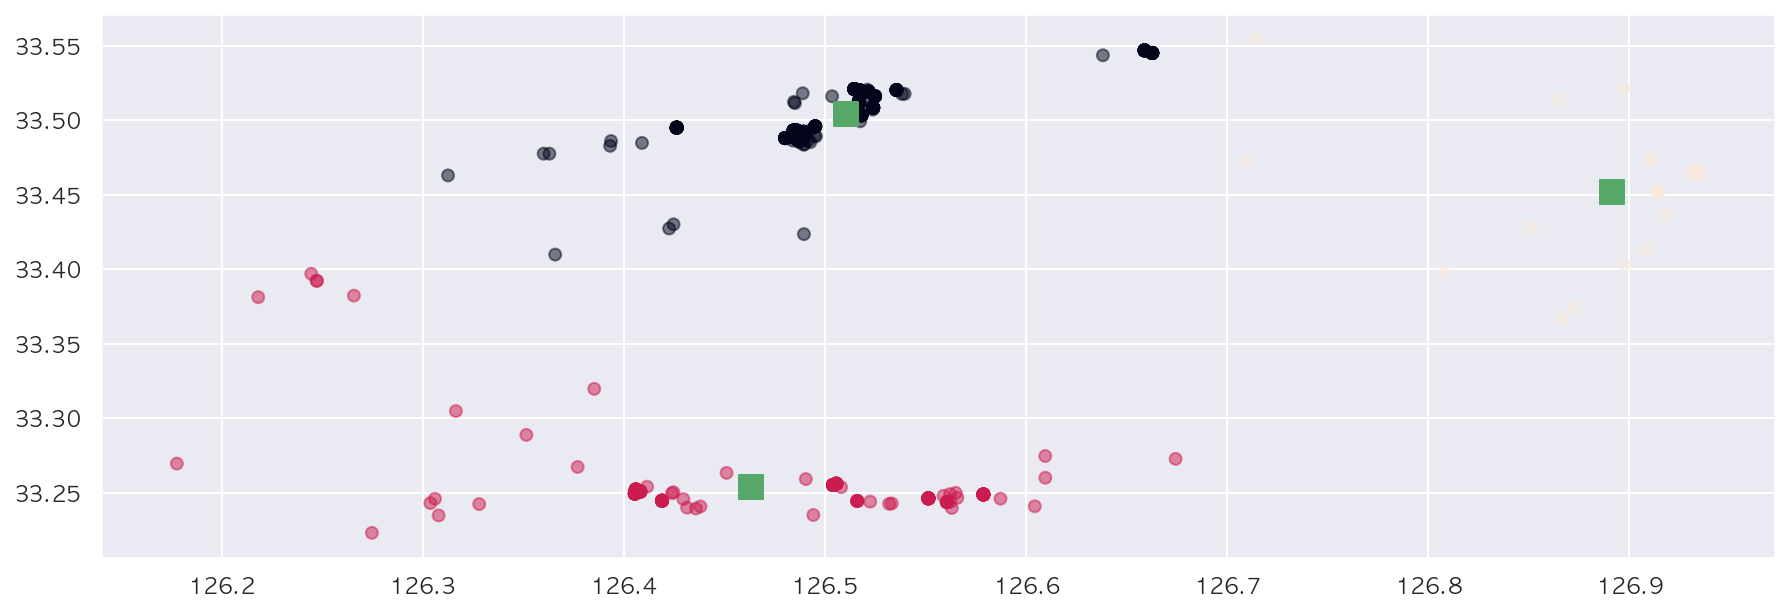

In [511]:
import matplotlib.pyplot as plt

centers = pd.DataFrame(model.cluster_centers_, columns=['x', 'y'])
center_x = centers['x']
center_y = centers['y']

fig = plt.figure(figsize=(15,5))
axes = plt.axes()
plt.scatter(feature['x'], feature['y'], c=feature['cluster'], alpha=0.5)
plt.scatter(center_x, center_y, s=150, marker='s', c='g')

plt.show()

----

<strong>ETC</strong><br><br>
제주도 내 숙박 업종 (2020.05 ~ 2020.08) 데이터 POINT_X, POINT_Y 좌표 위도, 경도 변환 수행

In [ ]:
# 좌표 변환
def change_lat_lng(path_x, path_y):
    
    itrf_x, itrf_y = path_x, path_y
    
    proj_UTMK = Proj(init='epsg:5178') #기존 좌표계: ITRF2000
    proj_WGS84 = Proj(init='epsg:4326') #변환할 좌표계
    
    x, y = transform(proj_UTMK, proj_WGS84, itrf_x, itrf_y)
    latlng = (x, y)
    
    return latlng

In [ ]:
raw_xy = hotel_spent[['POINT_X', 'POINT_Y']]
raw_xy

In [ ]:
# ITRF2000 좌표계 좌표
def get_transform_xy(raw_xy):
    transform_xy = []
    latlng_df = raw_xy
    
    for i in range(len(latlng_df)):
        raw_x = latlng_df['POINT_X'].iloc[i]
        raw_y = latlng_df['POINT_Y'].iloc[i]

        res = change_lat_lng(raw_x, raw_y)
        transform_xy.append(res)

    return transform_xy


raw_xy = hotel_spent[['POINT_X', 'POINT_Y']]
res_latlng = get_transform_xy(raw_xy)

get_x, get_y = [], []

for i in range(len(res_latlng)):
    x = str(res_latlng[i][0])
    y = str(res_latlng[i][1])
    
    get_x.append(x)
    get_y.append(y)

In [ ]:
hotel_spent['Proj_X'] = get_x
hotel_spent['Proj_Y'] = get_y

hotel_spent.reset_index(drop=True, inplace=True)
hotel_spent.tail(5)

In [ ]:
hotel_spent.to_csv("../datas/detailed_consume_type_data.csv", encoding='utf-8-sig')